In [1]:
import os, sys, glob, time, pdb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle, Wedge
from scipy import ndimage, signal
from skimage import morphology
from tqdm.notebook import tqdm
import multiprocessing
from multiprocessing import Pool
from importlib import reload
import socket

In [2]:
socket.gethostname()

'andes412.olcf.ornl.gov'

In [ ]:
if 'bsd-a100' in socket.gethostname():
    base_path = '/mnt/DGX01/Personal/lagergrenj/Codebase/'
elif 'jupyter-lagergrenj' in socket.gethostname():
    base_path = '/gpfs/alpine/syb105/proj-shared/Personal/lagergrenj/Codebase/'
    
sys.path.append(base_path)

In [2]:
#
# load sequences, dates, locations
#

# options
# meta_path = base_path + 'Data/Climatype/covid/clusters221215/'
# meta_name = 'metadata.tsv'
meta_path = base_path + 'Data/Climatype/covid/clusters220608/'
meta_name = 'dates_locations.tsv'

# get seq ids, dates, locs
sample_ids, dates, locations, continents, hosts = [], [], [], [], []
with open(meta_path + meta_name, 'r') as f:
    for i, line in enumerate(tqdm(f)):

        # pre-process
        line = line.replace('\n', '').lower().split('\t')

        # header
        if i == 0:
            header = line.copy()
            # id_idx = header.index('accession id')
            # date_idx = header.index('collection date')
            # location_idx = header.index('location')
            # host_idx = header.index('host')
            id_idx = header.index('seq_id')
            date_idx = header.index('collection_date')
            location_idx = header.index('location')
            continue

        # # only for humans
        # hosts.append(line[host_idx])
        # if line[host_idx] != 'human':
        #     continue

        # date 
        date = line[date_idx].split('-')
        if len(date) < 2 or int(date[0]) < 2019: 
            continue
        if len(date) == 2: 
            date = date + ['15']
        if (int(date[0]) == 2019) and (int(date[1]) < 12): 
            continue
        date = '-'.join(date)

        # sequence ID
        sample_id = line[id_idx].replace('epi_isl_', '')
        sample_id = sample_id.replace('_a', '').replace('_t', '')
        sample_id = int(sample_id)

        # location
        location = line[location_idx].split('/')[1].strip()
        continent = line[location_idx].split('/')[0].strip()

        # append
        sample_ids.append(sample_id)
        dates.append(date)
        locations.append(location)
        continents.append(continent)

0it [00:00, ?it/s]

In [3]:
#
# standardize locations
#

def standardize(x):
    x = x.replace('[', '').replace(']', '')
    x = x.replace('(', '').replace(')', '')
    x = x.replace('.', '').replace('\'', '')
    x = x.replace('-', '').replace('&', 'and')
    x = x.lower().strip()
    return x

# standardize locations
locations = [standardize(l) for l in tqdm(locations)]

  0%|          | 0/4093359 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

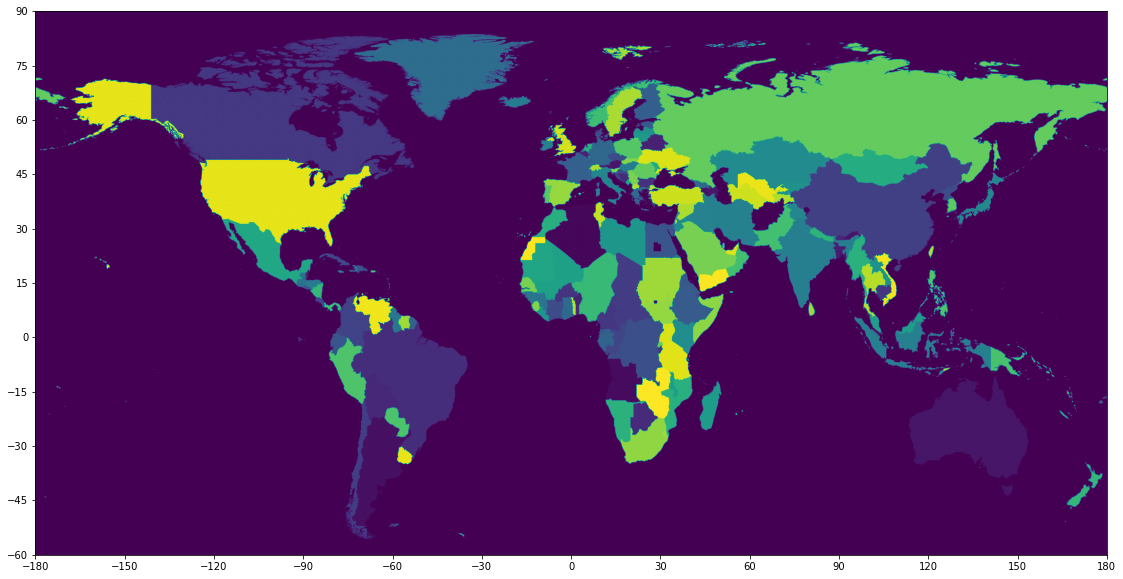

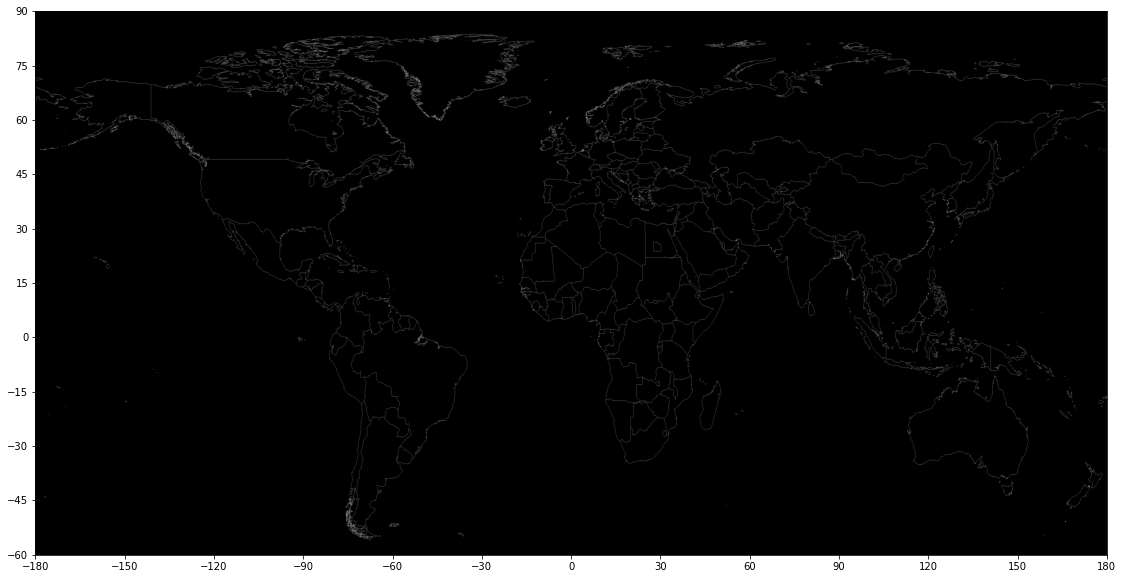

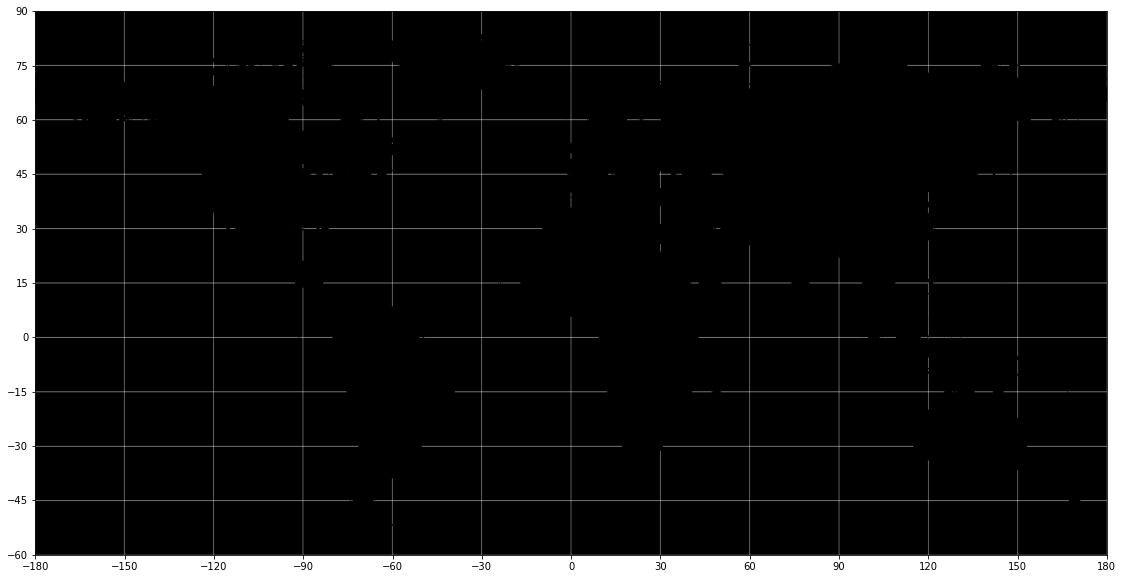

In [4]:
#
# load polygons
#

# options
polygon_path = base_path + 'Data/TerraClimate/Global8M/country_coords/'
polygon_names = [os.path.basename(f).replace('.npy', '') for f in glob.glob(polygon_path + '*.npy')]
polygon_names.sort()
figsize = 10

# load polygons
polygon_coords = []
for polygon in tqdm(polygon_names):
    polygon_coords.append(np.load(polygon_path + polygon+'.npy'))
    
# standardize polygon names
polygon_names = [standardize(p) for p in polygon_names]

# convert polygons to map
lat_min, lat_max = -60, 90
lng_min, lng_max = -180, 180
n_cols = 8639
n_rows = int(n_cols * (lat_max-lat_min) / (lng_max-lng_min))
world_map = np.zeros([n_rows, n_cols]).astype(int)
for i in range(len(polygon_coords)):
    c = polygon_coords[i].copy()
    c[:,0] = n_rows - (c[:,0]-lat_min) / (lat_max-lat_min) * n_rows
    c[:,1] = (c[:,1]-lng_min) / (lng_max-lng_min) * n_cols
    world_map[c[:,0].astype(int), c[:,1].astype(int)] = i + 1
    
# fill missing values
for col in np.argwhere(world_map.sum(0) == 0):
    world_map[:, col] = world_map[:, col-1]
idx = np.argwhere(world_map.sum(1) == 0)
mask = (idx > 500) * (idx < len(world_map) - 500)
for row in idx[mask]:
    world_map[row] = world_map[row-1]
    
# compute boundaries
v_boundaries = (world_map[1:] - world_map[:-1]) != 0
v_boundaries = np.concatenate([v_boundaries, np.zeros([1, world_map.shape[1]])], axis=0)
h_boundaries = (world_map[:, 1:] - world_map[:, :-1]) != 0
h_boundaries = np.concatenate([h_boundaries, np.zeros([world_map.shape[0], 1])], axis=1)
boundaries = (v_boundaries + h_boundaries).clip(0, 1).astype(bool)
boundaries = morphology.skeletonize(boundaries)

# make grid lines
gridlines = np.zeros_like(boundaries)
nlats, nlngs = boundaries.shape
rows = (nlats * (np.arange(lat_min, lat_max, 15) - lat_min)/(lat_max - lat_min)).astype(int)
cols = (nlngs * (np.arange(lng_min, lng_max, 30) - lng_min)/(lng_max - lng_min)).astype(int)
gridlines[rows-1], gridlines[:, cols-1] = 1, 1
gridlines[rows], gridlines[:, cols] = 1, 1
gridlines[rows+1], gridlines[:, cols+1] = 1, 1
gridlines[world_map > 0] = 0

# plot 
fig = plt.figure(figsize=[0.8*boundaries.shape[1]/boundaries.shape[0]*figsize, figsize])
plt.imshow(world_map/world_map.max(), extent=[lng_min, lng_max, lat_min, lat_max], aspect='auto')
plt.xticks(np.arange(lng_min, lng_max+1, 30))
plt.yticks(np.arange(lat_min, lat_max+1, 15))
plt.xlim([-180, 180])
plt.ylim([-60, 90])
plt.show()

# plot 
fig = plt.figure(figsize=[0.8*boundaries.shape[1]/boundaries.shape[0]*figsize, figsize])
plt.imshow(boundaries, extent=[lng_min, lng_max, lat_min, lat_max], cmap='gray', aspect='auto')
plt.xticks(np.arange(lng_min, lng_max+1, 30))
plt.yticks(np.arange(lat_min, lat_max+1, 15))
plt.xlim([-180, 180])
plt.ylim([-60, 90])
plt.show()

# plot 
fig = plt.figure(figsize=[0.8*boundaries.shape[1]/boundaries.shape[0]*figsize, figsize])
plt.imshow(gridlines, extent=[lng_min, lng_max, lat_min, lat_max], cmap='gray', aspect='auto')
plt.xticks(np.arange(lng_min, lng_max+1, 30))
plt.yticks(np.arange(lat_min, lat_max+1, 15))
plt.xlim([-180, 180])
plt.ylim([-60, 90])
plt.show()

In [5]:
#
# make dict to convert gisaid country to polygon name
#

converter = {country:country for country in polygon_names}
converter['united kingdom'] = 'uk of great britain and northern ireland'
converter['england'] = 'uk of great britain and northern ireland'
converter['usa'] = 'united states of america'
converter['iran'] = 'iran islamic republic of'
converter['south korea'] = 'republic of korea'
converter['us virgin islands'] = 'united states of america'
converter['north macedonia'] = 'the former yugoslav republic of macedonia'
converter['cote divoire'] = 'côte divoire'
converter['russia'] = 'russian federation'
converter['crimea'] = 'russian federation'
converter['wallis and futuna islands'] = 'france'
converter['brunei'] = 'brunei darussalam'
converter['republic of the congo'] = 'congo'
converter['cabo verde'] = 'cape verde'
converter['laos'] = 'lao peoples democratic republic'
converter['libya'] = 'libyan arab jamahiriya'
converter['syria'] = 'syrian arab republic'
converter['tanzania'] = 'united republic of tanzania'
converter['the bahamas'] = 'bahamas'
converter['kosovo'] = None
converter['saint barthelemy'] = None
converter['moldova'] = None
converter['saint martin'] = None
converter['canary islands'] = None
converter['bonaire'] = None
converter['curacao'] = None
converter['eswatini'] = None
converter['palestine'] = None
converter['sint eustatius'] = None
converter['sint maarten'] = None

In [6]:
#
# load clusters, assign 4 largest to each WHO variant
#

# options
# cluster_path = base_path + 'Data/Climatype/covid/clusters221215/'
cluster_path = base_path + 'Data/Climatype/covid/clusters220608/'
cluster_name = 'clusters_inflation-1.2.tsv'
variant_path = base_path + 'Data/Climatype/covid/'
variant_name = 'mcl-cluster_cdc-strains.tsv'
country_name = 'countries_formatted.txt'
remove_list = ['Eta', 'Kappa', 'Mu', 'Zeta']

# parse clusters
clusters = []
with open(cluster_path + cluster_name, 'r') as f:
    for i, line in enumerate(tqdm(f, total=21836)):
        line = line.replace('\n', '').split(' ')
        line = [int(l.replace('_A', '').replace('_T', '')) for l in line if l != '']
        clusters.append(line)
        
# parse variants
with open(variant_path + variant_name, 'r') as f:
    variants = f.read()
variants = [v.split('\t') for v in variants.split('\n')][:-1]
variant_names = variants[0][1:]
variant_counts = np.array(variants[1:], dtype=float)
variant_idxs = variant_counts[:, 0].astype(int)
variant_counts = variant_counts[:, 1:].astype(int)
keep_idx = [i for i in range(len(variant_names)) if variant_names[i] not in remove_list]
variant_counts = variant_counts[:, np.array(keep_idx)]
variant_names = [v for i, v in enumerate(variant_names) if i in keep_idx]

# align variants with clusters
variant_counts = variant_counts[variant_idxs.argsort()]
variant_idxs = variant_idxs[variant_idxs.argsort()]
clusters = [clusters[i] for i in range(len(clusters)) if i in variant_idxs]
cluster_variants = variant_counts.argmax(-1)
cluster_sizes = np.array([len(c) for c in clusters])
idx_sorted = np.argsort(cluster_sizes)[::-1]

# store top 4 clusters for each cdc variant
variant_clusters = [[] for i in range(len(variant_names))]
variant_cluster_counts = [0 for i in range(len(variant_names))]
for i in idx_sorted:
    variant_idx = variant_counts[i].argmax()
    if variant_cluster_counts[variant_idx] == 4:
        continue
    variant_clusters[variant_idx].append(clusters[i])
    variant_cluster_counts[variant_idx] += 1
clusters = sum(variant_clusters, []) # combine lists

# # combine small "miscellaneous" clusters into one 
# sizes = np.array([len(c) for c in clusters])
# idx_sorted = np.argsort(sizes)[::-1]
# large_clusters = [clusters[i] for i in idx_sorted[:top_n-1]]
# small_clusters = []
# for i in idx_sorted[top_n-2:]:
#     small_clusters += clusters[i]
# clusters = large_clusters #+ [small_clusters]

  0%|          | 0/21836 [00:00<?, ?it/s]

In [15]:
#
# build data tensor 
#

# options
by_country = True # by country or by continent

# make sequence dictionary
sequence_dict = {s: {'date':d, 'location':l, 'continent':c} for s, d, l, c in zip(sample_ids, dates, locations, continents)}

# make set of unique dates
dates_u = list(set(dates))
dates_u.sort()
date2idx = {d:i for i, d in enumerate(dates_u)}

# make polygon dictionary
poly2idx = {p:i for i, p in enumerate(polygon_names)}

if by_country:

    # build data tensor [dates, countries, clusters]
    data = np.zeros([len(dates_u), len(polygon_names), len(clusters)], dtype=np.float32)
    present, missing = 0, 0
    for c_idx, cluster in enumerate(tqdm(clusters)): # loop over clusters
        for s_idx, sequence in enumerate(cluster): # loop over sequences
            if sequence in sequence_dict:
                country = converter[sequence_dict[sequence]['location']]
                date = sequence_dict[sequence]['date']
                if country is not None:
                    data[date2idx[date], poly2idx[country], c_idx] += 1
                else:
                    missing += 1
            else:
                missing += 1
                
else:
    
    continents_u = ['north america', 'europe'] # list(np.unique(continents))

    # build data tensor [dates, continents, clusters]
    data = np.zeros([len(dates_u), len(continents_u), len(clusters)], dtype=np.float32)
    present, missing = 0, 0
    for c_idx, cluster in enumerate(tqdm(clusters)): # loop over clusters
        for s_idx, sequence in enumerate(cluster): # loop over sequences
            if sequence in sequence_dict:
                continent = sequence_dict[sequence]['continent']
                date = sequence_dict[sequence]['date']
                if continent in continents_u:
                    data[date2idx[date], continents_u.index(continent), c_idx] += 1
                else:
                    missing += 1
            else:
                missing += 1
            
# compute moving average
w = 7
moving_averages = signal.convolve(data, np.ones([w,1,1])/w, mode='valid').clip(0, np.inf)
dates_u = dates_u[w-1:]

# clip to start date
start_date = dates_u.index('2020-03-01')
end_date = dates_u.index('2021-10-01')
moving_averages = moving_averages[start_date:end_date]
dates_u = dates_u[start_date:end_date]

# order from first to last
m = moving_averages
cluster_idx = np.argsort([m[:, :, i].sum(-1).argmax() for i in range(m.shape[-1])])
cluster_idx = np.arange(m.shape[-1])
moving_averages = moving_averages[:, :, cluster_idx]

  0%|          | 0/24 [00:00<?, ?it/s]

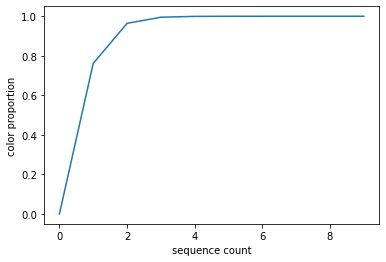

In [14]:
# define color smoothing function
def sigmoid(x):
    return 1/(1 + np.exp(-x))

x = np.arange(10)
y = 2*(sigmoid(2*x)-0.5)
plt.plot(x, y)
plt.xlabel('sequence count')
plt.ylabel('color proportion')
plt.show()

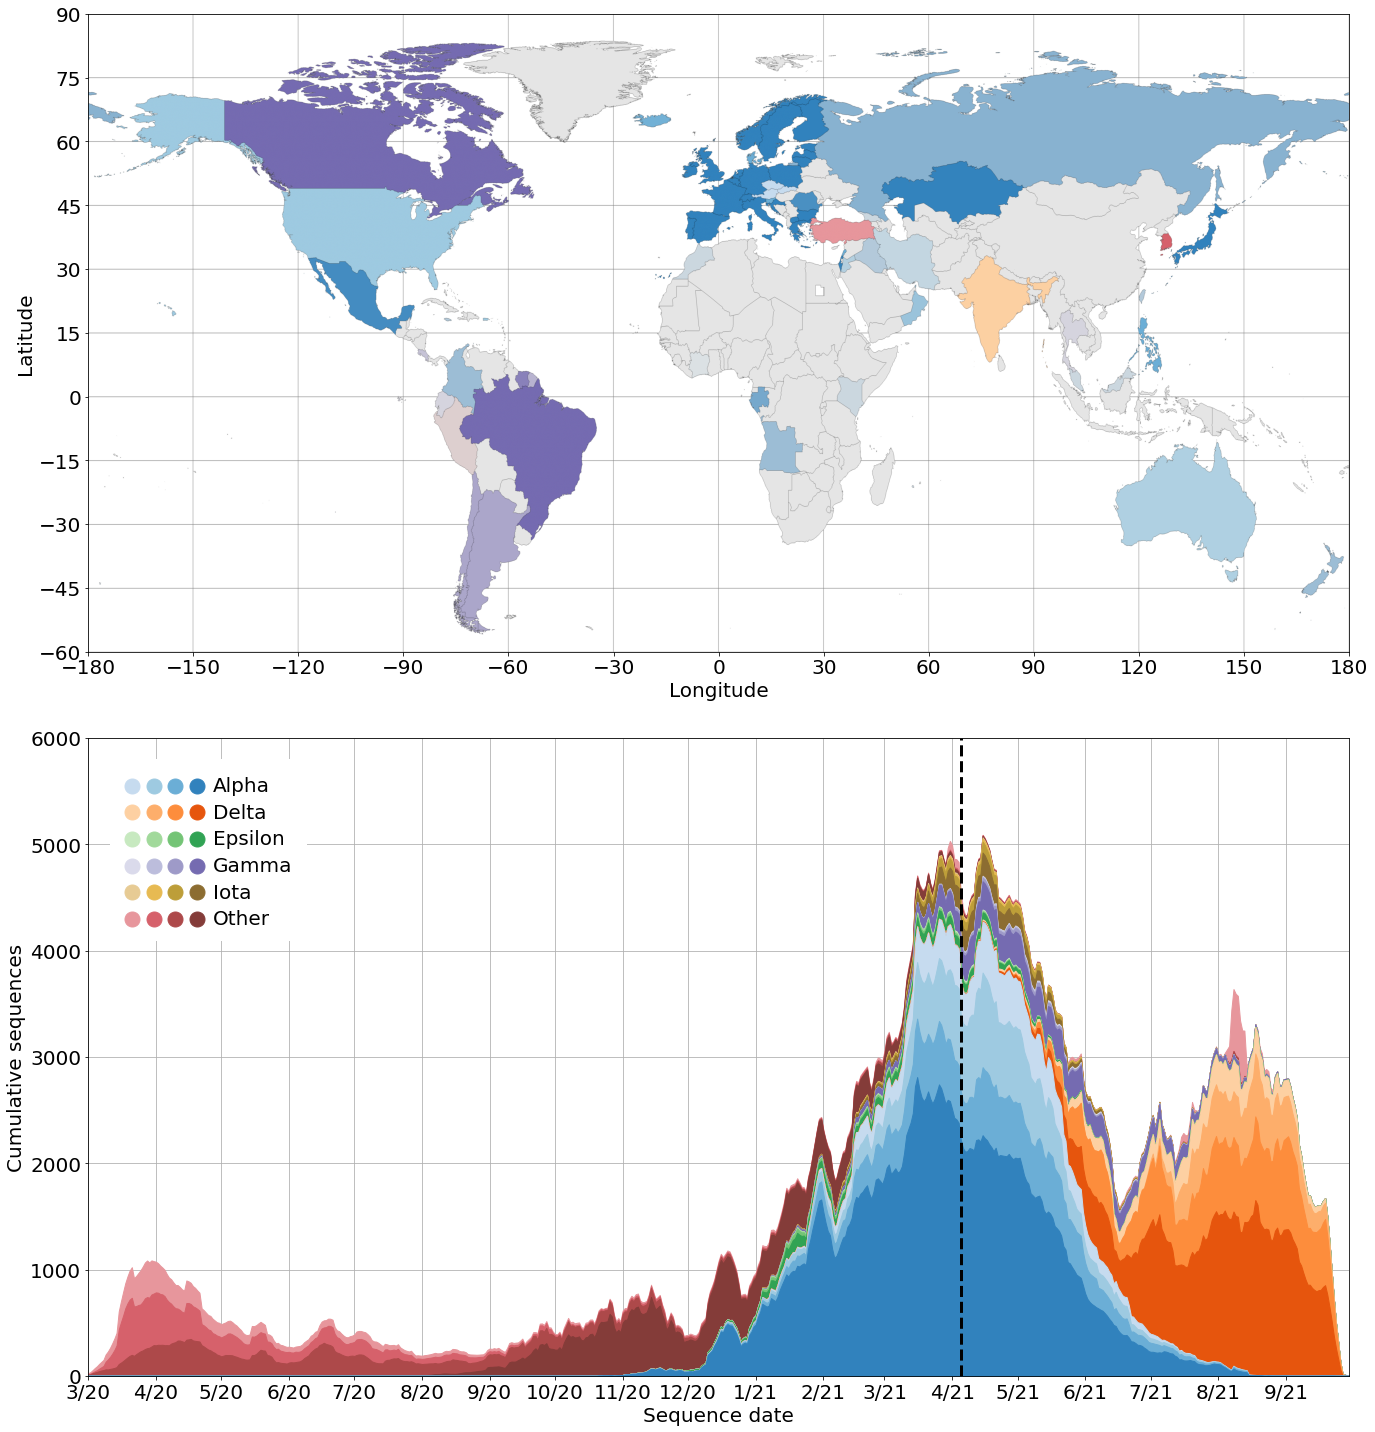

In [13]:
#
# plot geospatial timeseries BY COUNTRY
#

# options
figsize = 10
save_path = base_path + 'Projects/PASC/figures/covid/maps/'
save_name = 'covid_map_{0}'
save = False

def sigmoid(x):
    return 1/(1 + np.exp(-x))
    
def do_the_thing(snap_date):

    # define plot colors [clusters, 3]
    colors = np.concatenate([
        matplotlib.cm.tab20c(np.arange(0, 4))[:, :-1][::-1],
        matplotlib.cm.tab20c(np.arange(4, 8))[:, :-1][::-1],
        matplotlib.cm.tab20c(np.arange(8, 12))[:, :-1][::-1],
        matplotlib.cm.tab20c(np.arange(12, 16))[:, :-1][::-1],
        matplotlib.cm.tab20b(np.arange(8, 12))[:, :-1][::-1],
        matplotlib.cm.tab20b(np.arange(12, 16))[:, :-1][::-1]][::-1])

    # book keeping
    n_dates, n_countries, n_clusters = moving_averages.shape
    moving_average = moving_averages[dates_u.index(snap_date)]
    total_cases = np.round(moving_averages.sum(axis=(1, 2)))
    cluster_cases = np.round(moving_averages.sum(axis=1))
    cluster_sums = np.cumsum(cluster_cases, axis=-1)

    # define timeseries plot ticks
    tick_idx, tick_dates = [], []
    for year in range(2019, 2023):
        for month in range(1, 13):
            date = str(year) + '-' + str(month).zfill(2)
            for i, d in enumerate(dates_u):
                if date in d:
                    tick_idx.append(i)
                    tick_dates.append('/'.join([str(int(date.split('-')[1])), date.split('-')[0][2:]]))
                    break

    # build world map
    image = np.ones([nlats, nlngs, 3])
    image[world_map > 0] = 0.9
    for c_idx in range(n_countries):
        sequences = moving_average[c_idx]
        if sequences.sum() > 0: # only plot if there are sequences
            rows, cols = np.argwhere(world_map == c_idx + 1).T
            cluster_idx = sequences.argmax()
            color = colors[-cluster_idx-1]
            s = 2*(sigmoid(2*sequences[cluster_idx])-0.5)
            color = s*color + (1-s)*0.9
            image[rows, cols] = color
    image[boundaries == 1] = 0
    image[gridlines == 1] = 0.5

    # initialize plot
    fig = plt.figure(figsize=(0.8*nlngs/nlats*figsize, 2*figsize))

    # plot world map
    ax = fig.add_subplot(2, 1, 1)
    plt.imshow(image, extent=[lng_min, lng_max, lat_min, lat_max], aspect='auto')
    plt.xticks(np.arange(lng_min, lng_max+1, 30), fontsize=20)
    plt.xlabel('Longitude', fontsize=20)
    plt.yticks(np.arange(lat_min, lat_max+1, 15), fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    plt.xlim([lng_min, lng_max])
    plt.ylim([lat_min, lat_max])

    # plot timeseries
    ax = fig.add_subplot(2, 1, 2)
    plt.rcParams['axes.axisbelow'] = True
    for c_idx in range(cluster_sums.shape[1]):
        plt.fill_between(np.arange(len(cluster_sums)), cluster_sums[:,-c_idx-1], color=colors[c_idx])
    plt.plot([dates_u.index(snap_date), dates_u.index(snap_date)], [0, 6000], 'k--', linewidth=3)
    plt.ylim([0, 6000])
    plt.xlim([0, len(total_cases)-1])
    plt.xticks(ticks=tick_idx, labels=tick_dates, rotation=0, fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid()

    # plot legend
    plt.fill_between([10, 100], 4100, 5800, color='white') # white box for legend to sit on
    for c_idx in range(0, cluster_cases.shape[1]):
        c = colors[c_idx]
        plt.plot(20 + 10*(c_idx%4), 4300+250*(c_idx//4), 'o', markersize=15, c=c)
        if c_idx%4 == 3:
            plt.text(27 + 10*(c_idx%4), 4300+250*(c_idx//4), variant_names[-(c_idx//4)-1], 
                 fontsize=20,
                 verticalalignment='center', 
                 horizontalalignment='left')
    plt.xlabel('Sequence date', fontsize=20)
    plt.ylabel('Cumulative sequences', fontsize=20)

    plt.tight_layout(h_pad=3)
    if save:
        plt.savefig(save_path + save_name.format(snap_date) + '.svg')
        plt.savefig(save_path + save_name.format(snap_date) + '.png', dpi=150)
        plt.clf()
        plt.close('all')
    else:
        plt.show()
        
if by_country: # only do if taking country view (skip for continental)
    if save:
        with Pool(processes=128) as pool:
            pool.map(do_the_thing, dates_u[::-1], chunksize=1)
    else:
        do_the_thing(dates_u[400])

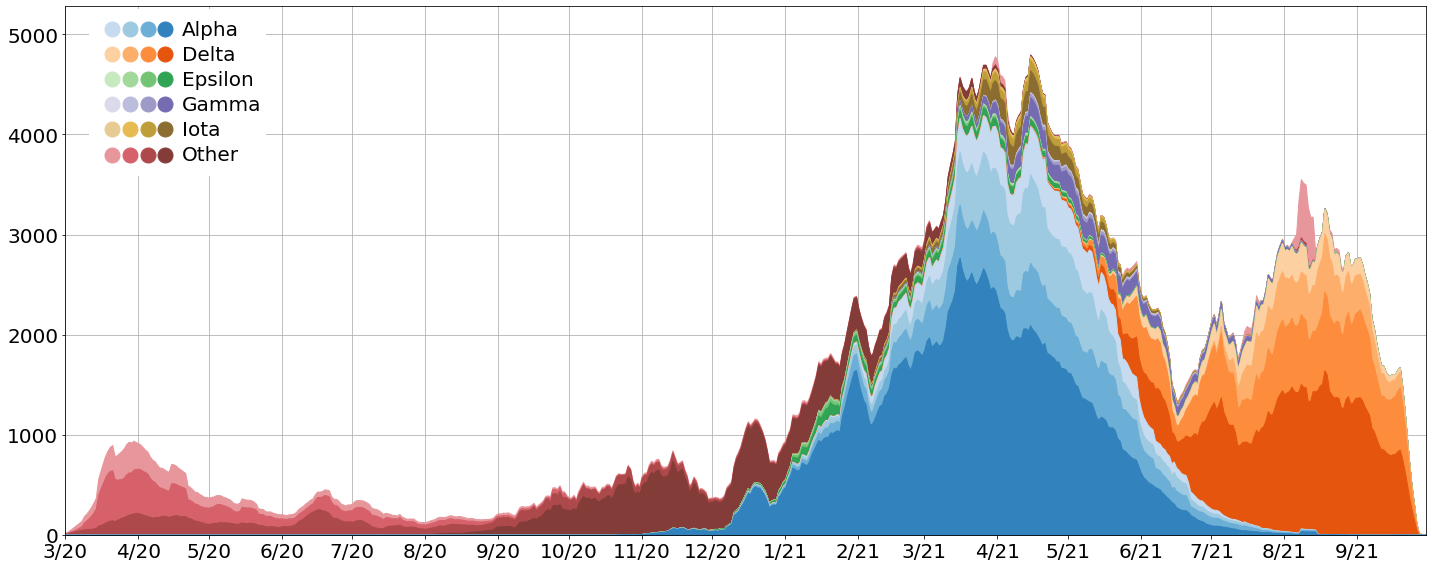

In [17]:
#
# top 4 clusters per variant together
#

if not by_country:

    # [clusters, 3]
    colors = np.concatenate([
        matplotlib.cm.tab20c(np.arange(0, 4))[:, :-1][::-1],
        matplotlib.cm.tab20c(np.arange(4, 8))[:, :-1][::-1],
        matplotlib.cm.tab20c(np.arange(8, 12))[:, :-1][::-1],
        matplotlib.cm.tab20c(np.arange(12, 16))[:, :-1][::-1],
        matplotlib.cm.tab20b(np.arange(8, 12))[:, :-1][::-1],
        matplotlib.cm.tab20b(np.arange(12, 16))[:, :-1][::-1],
        ][::-1])

    total_cases = np.round(moving_averages.sum(-1).sum(-1)) # [timepoints]
    cluster_cases = np.round(moving_averages.sum(1)) # [timepoints, clusters]
    cluster_sums = np.cumsum(cluster_cases, axis=-1)

    tick_idx, tick_dates = [], []
    for year in range(2019, 2023):
        for month in range(1, 13):
            date = str(year) + '-' + str(month).zfill(2)
            for i, d in enumerate(dates_u):
                if date in d:
                    tick_idx.append(i)
                    tick_dates.append('/'.join([str(int(date.split('-')[1])), date.split('-')[0][2:]]))
                    break
    y_min, y_max = 0, 1.1*total_cases.max()

    fig = plt.figure(figsize=(20, 8))

    # plot cluster time series
    for c_idx in range(cluster_sums.shape[1]):
        plt.fill_between(np.arange(len(cluster_sums)), cluster_sums[:,-c_idx-1], color=colors[c_idx])
    plt.ylim([y_min, y_max])
    plt.xlim([0, len(total_cases)-1])
    plt.xticks(ticks=tick_idx, labels=tick_dates, rotation=0, fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid()

    plt.rcParams['axes.axisbelow'] = True

    # plot legend
    plt.fill_between([10, 85], 3600, 5250, color='white') # white box for legent to sit on
    for c_idx in range(0, cluster_cases.shape[1]):
        c = colors[c_idx]
        plt.plot(20 + 7.5*(c_idx%4), 3800+250*(c_idx//4), 'o', markersize=15, c=c)
        if c_idx%4 == 3:
            plt.text(27 + 7.5*(c_idx%4), 3800+250*(c_idx//4), variant_names[-(c_idx//4)-1], 
                 fontsize=20,
                 verticalalignment='center', 
                 horizontalalignment='left')

    plt.tight_layout()
    plt.show()

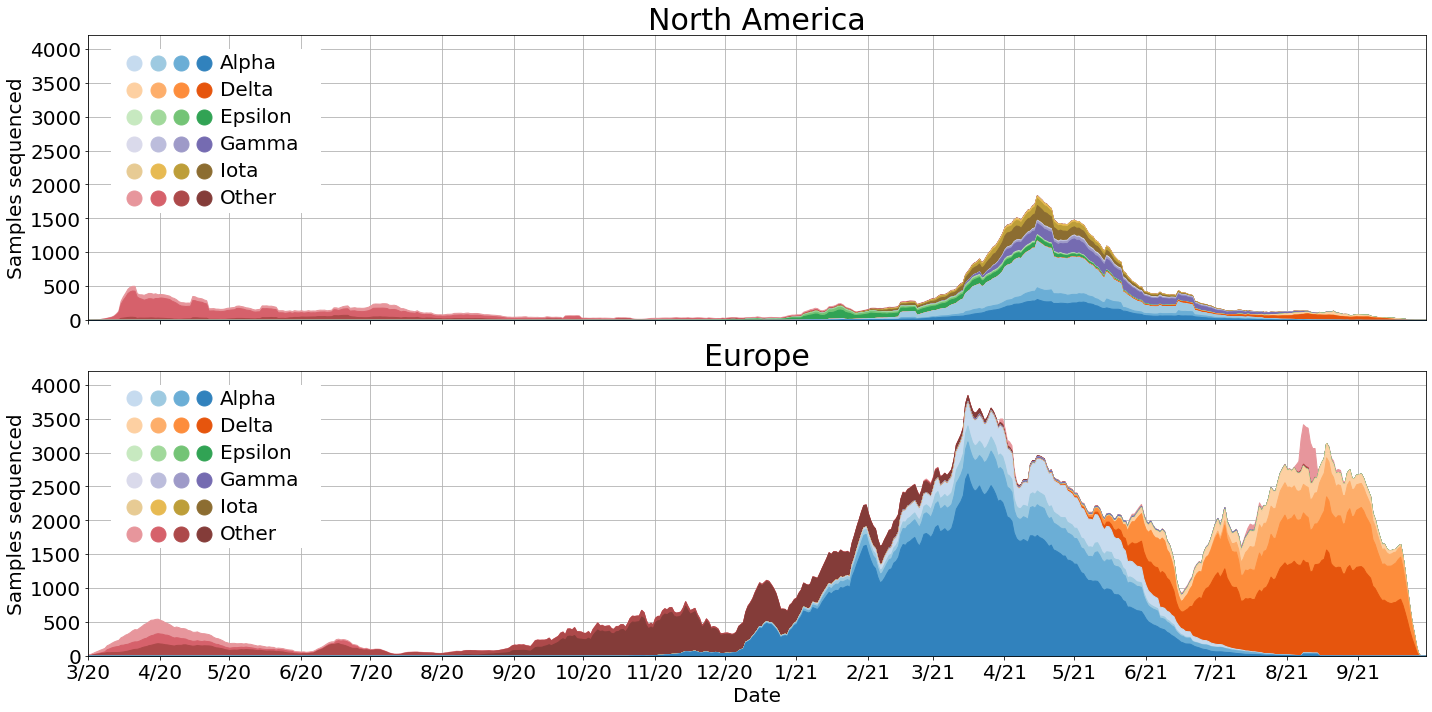

In [16]:
#
# top 4 clusters per variant together by CONTINENT
#

# options
save_path = base_path + 'Projects/PASC/figures/covid/'
save_name = 'covid_continents'
save = False

if not by_country:

    # [clusters, 3]
    colors = np.concatenate([
        matplotlib.cm.tab20c(np.arange(0, 4))[:, :-1][::-1],
        matplotlib.cm.tab20c(np.arange(4, 8))[:, :-1][::-1],
        matplotlib.cm.tab20c(np.arange(8, 12))[:, :-1][::-1],
        matplotlib.cm.tab20c(np.arange(12, 16))[:, :-1][::-1],
        matplotlib.cm.tab20b(np.arange(8, 12))[:, :-1][::-1],
        matplotlib.cm.tab20b(np.arange(12, 16))[:, :-1][::-1],
        ][::-1])

    fig = plt.figure(figsize=(20, len(continents_u)*5))
    plt.rcParams['axes.axisbelow'] = True

    for cont_idx in range(len(continents_u)):

        continent = ' '.join([c.capitalize() for c in continents_u[cont_idx].split(' ')])
        start = cont_idx
        stop = cont_idx + 1

        ax = fig.add_subplot(len(continents_u), 1, cont_idx+1)

        total_cases = np.round(moving_averages[:, start:stop].sum(-1).sum(-1)) # [timepoints]
        cluster_cases = np.round(moving_averages[:, start:stop].sum(1)) # [timepoints, clusters]
        cluster_sums = np.cumsum(cluster_cases, axis=-1)

        tick_idx, tick_dates = [], []
        for year in range(2019, 2023):
            for month in range(1, 13):
                date = str(year) + '-' + str(month).zfill(2)
                for i, d in enumerate(dates_u):
                    if date in d:
                        tick_idx.append(i)
                        tick_dates.append('/'.join([str(int(date.split('-')[1])), date.split('-')[0][2:]]))
                        break
        y_min, y_max = 0, 4200

        # plot cluster time series
        for c_idx in range(cluster_sums.shape[1]):
            plt.fill_between(np.arange(len(cluster_sums)), cluster_sums[:,-c_idx-1], color=colors[c_idx])
        plt.ylim([y_min, y_max])
        plt.xlim([0, len(total_cases)-1])
        if cont_idx < len(continents_u)-1:
            plt.xticks(ticks=tick_idx, labels=['' for t in tick_idx], rotation=0, fontsize=20)
        else:
            plt.xticks(ticks=tick_idx, labels=tick_dates, rotation=0, fontsize=20)
            plt.xlabel('Date', fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel('Samples sequenced', fontsize=20)
        plt.grid()

        plt.rcParams['axes.axisbelow'] = True

        # plot legend
        plt.fill_between([10, 100], 3600-2000, 5500-1500, color='white') # white box for legent to sit on
        for c_idx in range(0, cluster_cases.shape[1]):
            c = colors[c_idx]
            plt.plot(20 + 10*(c_idx%4), 3800-2000+400*(c_idx//4), 'o', markersize=15, c=c)
            if c_idx%4 == 3:
                plt.text(27 + 10*(c_idx%4), 3800-2000+400*(c_idx//4), variant_names[-(c_idx//4)-1], 
                     fontsize=20,
                     verticalalignment='center', 
                     horizontalalignment='left')
        plt.title(continent, fontsize=30)

    if save:
        plt.savefig(save_path + save_name + '.svg', bbox_inches='tight')
        plt.savefig(save_path + save_name + '.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

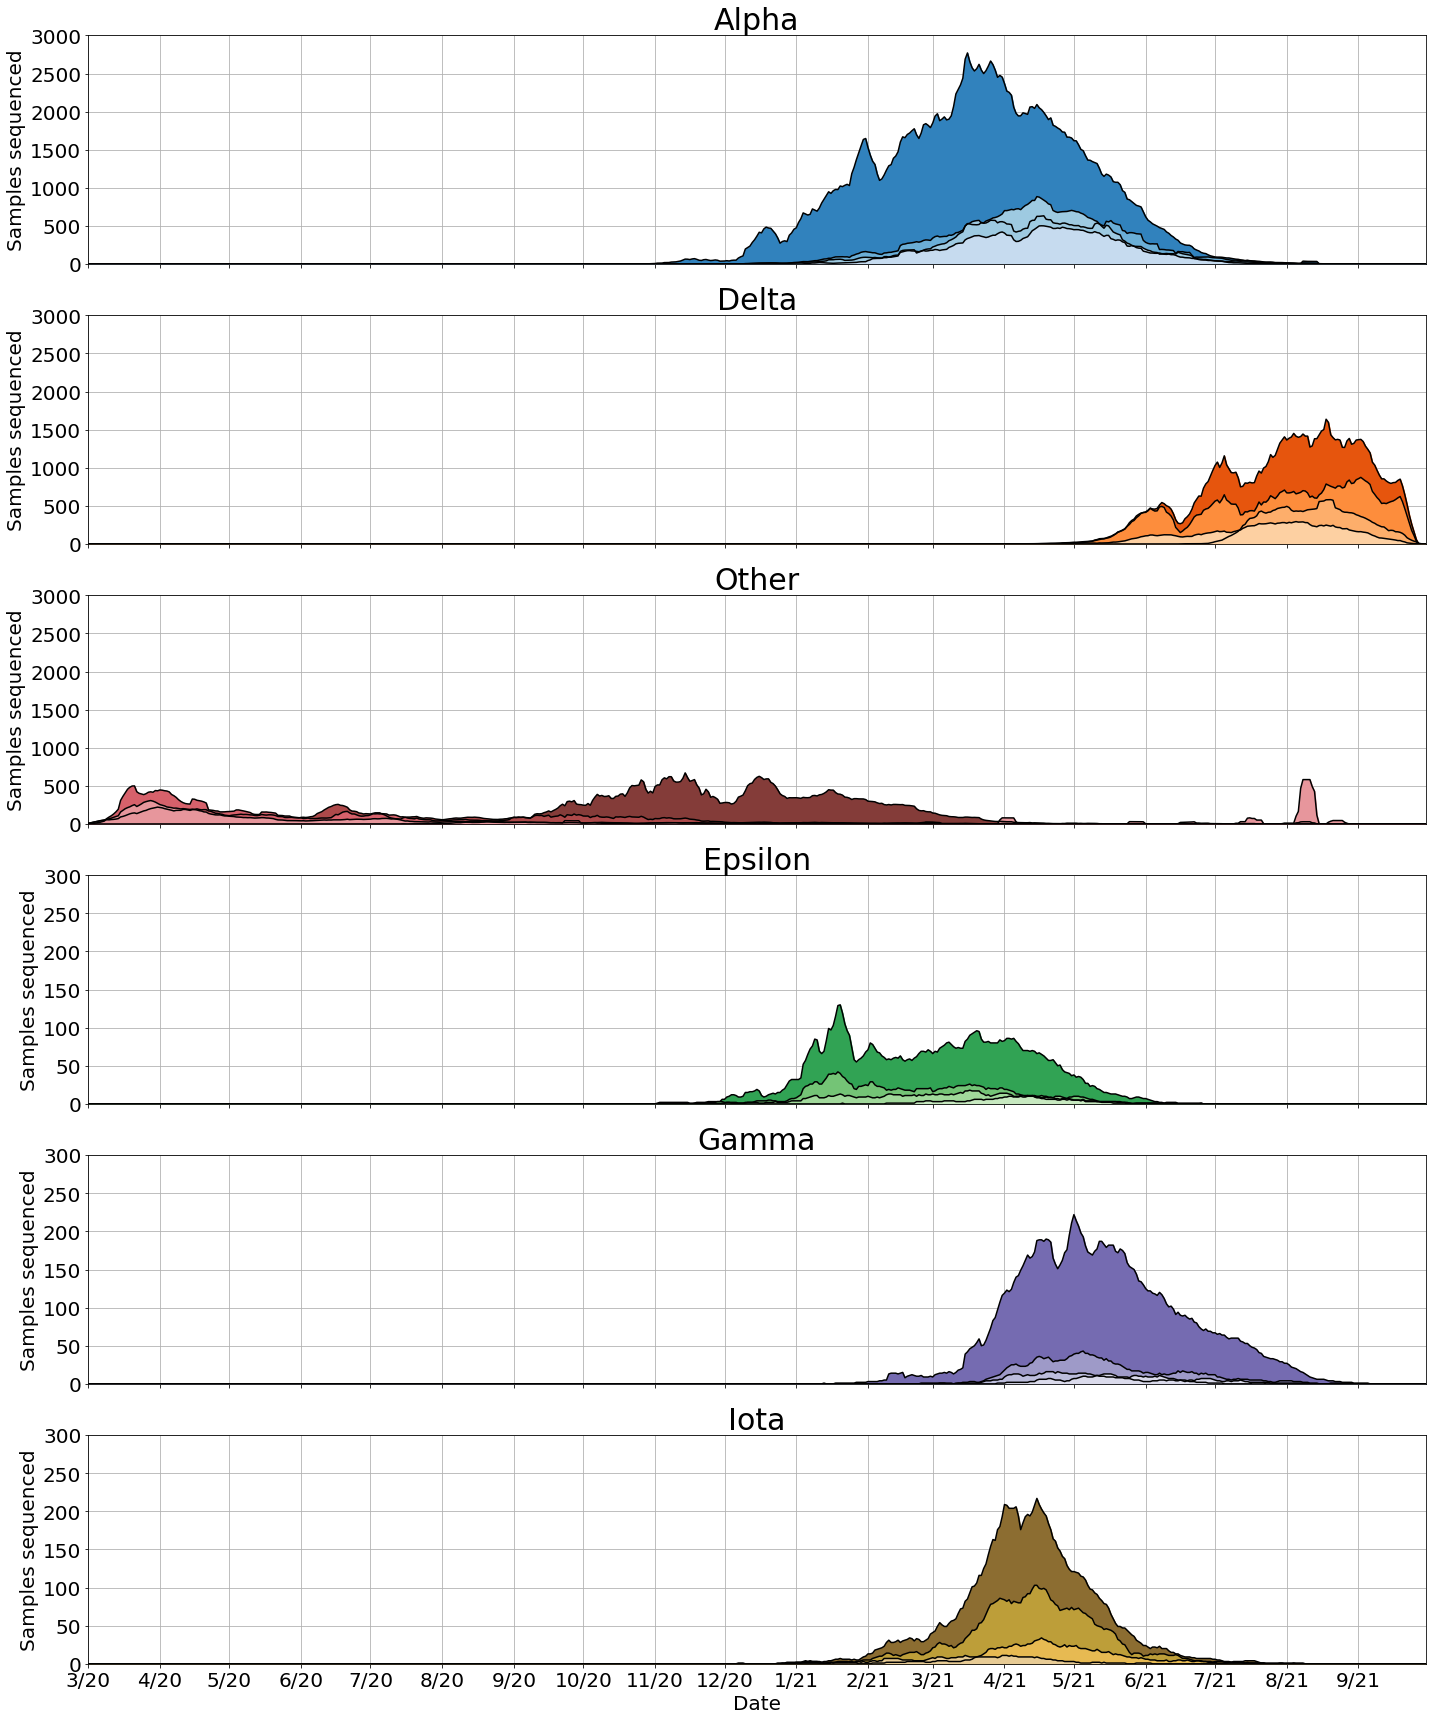

In [18]:
#
# top 4 clusters per variant separate
#

# options
save_path = base_path + 'Projects/PASC/figures/covid/'
save_name = 'covid_cdcstrains'
save = False

if not by_country:

    fig = plt.figure(figsize=(20, len(variant_names)*4))

    for enum, v_idx in enumerate([0, 1, 5, 2, 3, 4]):

        ax = fig.add_subplot(len(variant_names), 1, enum+1)

        start = v_idx*4
        stop = (v_idx+1)*4

        # [clusters, 3]
        colors = np.concatenate([
            matplotlib.cm.tab20c(np.arange(0, 4))[:, :-1],
            matplotlib.cm.tab20c(np.arange(4, 8))[:, :-1],
            matplotlib.cm.tab20c(np.arange(8, 12))[:, :-1],
            matplotlib.cm.tab20c(np.arange(12, 16))[:, :-1],
            matplotlib.cm.tab20b(np.arange(8, 12))[:, :-1],
            matplotlib.cm.tab20b(np.arange(12, 16))[:, :-1],
            ])[start:stop]

        total_cases = np.round(moving_averages[:, :, start:stop].sum(-1).sum(-1)) # [timepoints]
        cluster_cases = np.round(moving_averages[:, :, start:stop].sum(1)) # [timepoints, clusters]
        cluster_sums = np.cumsum(cluster_cases, axis=-1)

        tick_idx, tick_dates = [], []
        for year in range(2019, 2023):
            for month in range(1, 13):
                date = str(year) + '-' + str(month).zfill(2)
                for i, d in enumerate(dates_u):
                    if date in d:
                        tick_idx.append(i)
                        tick_dates.append('/'.join([str(int(date.split('-')[1])), date.split('-')[0][2:]]))
                        break


        # plot cluster time series
        for c_idx in range(cluster_sums.shape[1]):
            plt.fill_between(np.arange(len(cluster_sums)), cluster_cases[:,c_idx], color=colors[c_idx], alpha=1)
        for c_idx in range(cluster_sums.shape[1]):
            plt.plot(np.arange(len(cluster_sums)), cluster_cases[:,c_idx], color='k')#colors[c_idx])
        if total_cases.max() > 500:
            plt.ylim([0, 3000])
        else:
            plt.ylim([0, 300])
        plt.xlim([0, len(total_cases)-1])
        if enum < 5:
            plt.xticks(ticks=tick_idx, labels=['' for t in tick_idx], rotation=0, fontsize=20)
        else:
            plt.xticks(ticks=tick_idx, labels=tick_dates, rotation=0, fontsize=20)
            plt.xlabel('Date', fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel('Samples sequenced', fontsize=20)
        plt.grid()
        plt.title(variant_names[v_idx], fontsize=30)

        plt.rcParams['axes.axisbelow'] = True

    if save:
        plt.savefig(save_path + save_name + '.svg', bbox_inches='tight')
        plt.savefig(save_path + save_name + '.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()